In [49]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("data/46241-0002_en_flat.csv", delimiter=";")

# Step 2: Select relevant columns and rename them for clarity
df_cleaned = df[[
    "time",  # Year
    "1_variable_attribute_label",  # Month
    "4_variable_attribute_label",  # Accident location
    "3_variable_attribute_label",  # Accident type
    "value"  # Number of accidents
]].rename(columns={
    "time": "Year",
    "1_variable_attribute_label": "Month",
    "4_variable_attribute_label": "Location",
    "3_variable_attribute_label": "Accident_Type",
    "value": "Accident_Count"
})

# Step 3: Forward-fill missing year values (assigns the last valid year to missing rows)
df_cleaned["Year"] = df_cleaned["Year"].ffill()

# Step 4: Replace missing values in other columns with "Unknown"
df_cleaned["Month"].fillna("Unknown", inplace=True)
df_cleaned["Location"].fillna("Unknown", inplace=True)
df_cleaned["Accident_Type"].fillna("Unknown", inplace=True)

# Step 5: Convert data types
df_cleaned["Year"] = df_cleaned["Year"].astype(int)
df_cleaned["Accident_Count"] = pd.to_numeric(df_cleaned["Accident_Count"], errors="coerce").fillna(0).astype(int)

# Step 6: Create a new column for Year (separate from the Date column)
df_cleaned['Year_Column'] = df_cleaned['Year']

# Step 7: Combine "Year" and "Month" into a single "Date" column (for datetime representation)
month_mapping = {
    "Januar": "January", "Februar": "February", "März": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Dezember": "December"
}
df_cleaned["Month"] = df_cleaned["Month"].replace(month_mapping)

# Create a new Date column and convert it to datetime format
df_cleaned["Date"] = df_cleaned["Year"].astype(str) + "-" + df_cleaned["Month"]
df_cleaned["Date"] = pd.to_datetime(df_cleaned["Date"], format="%Y-%B", errors="coerce")

# Step 8: Categorize accident types into broader categories
df_cleaned["Accident_Category"] = df_cleaned["Accident_Type"].apply(lambda x:
    "Personal Injury" if "Personal injury" in x else
    "Material Damage" if "mat.damage" in x else
    "Intoxication" if "intoxication" in x else
    "Other Material Damage" if "Other accidents involving material damage" in x else
    "Total" if "Total" in x else
    "Unknown"
)

# Step 9: Drop original "Year" and "Month" columns, since "Date" now replaces them
df_cleaned.drop(columns=["Year", "Month"], inplace=True)

# Step 10: Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("cleaned_traffic_accidents_with_separate_year.csv", index=True)

# ✅ Done! Display a preview of the first 10 rows
df_cleaned.head()


C:\Users\sebas\AppData\Local\Temp\ipykernel_32396\995126761.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["Month"].fillna("Unknown", inplace=True)
C:\Users\sebas\AppData\Local\Temp\ipykernel_32396\995126761.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

,Location,Accident_Type,Accident_Count,Year_Column,Date,Accident_Category
0,On motorways/freeways,Personal injury accidents,1684,2021,2021-10-01,Personal Injury
1,On motorways/freeways,Total,12501,2022,2022-12-01,Total
2,Inside built-up areas,Total,168802,2018,2018-06-01,Total
3,Inside built-up areas,Serious acc. invol. mat.damage in the nearer s...,5192,2011,2011-12-01,Material Damage
4,Total,Total,207831,2015,2015-05-01,Total


In [50]:
df_cleaned.describe()
# Filter out the data from 2024
df_cleaned = df_cleaned[df_cleaned['Year_Column'] != 2024]

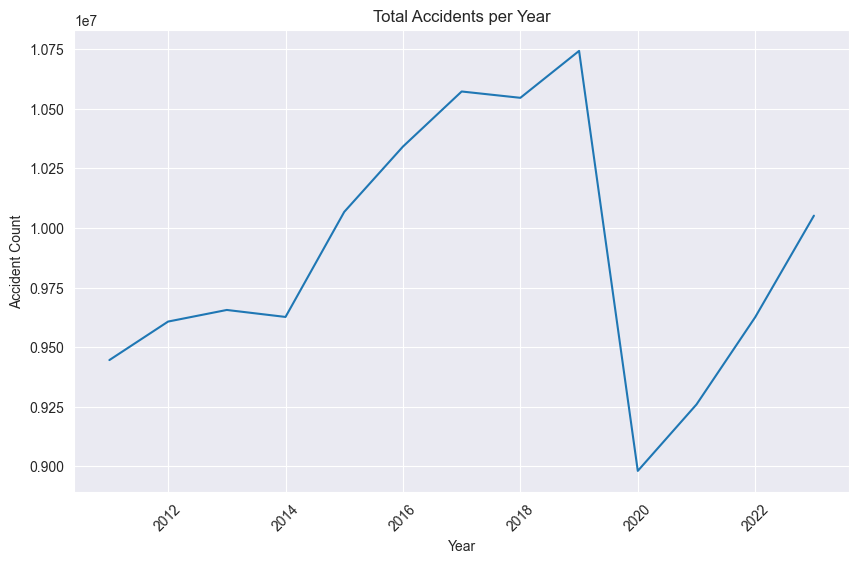

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by Year and sum the Accident_Count
df_yearly = df_cleaned.groupby('Year_Column')['Accident_Count'].sum().reset_index()

# Plot the total accident count by year
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_yearly, x='Year_Column', y='Accident_Count')
plt.title('Total Accidents per Year')
plt.xlabel('Year')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.show()

                                            Location  Accident_Count
0                              Inside built-up areas        47194376
1                              On motorways/freeways         4126010
2  Outside built-up areas (excl. motorways/freeways)        12941470
3                                              Total        64261856


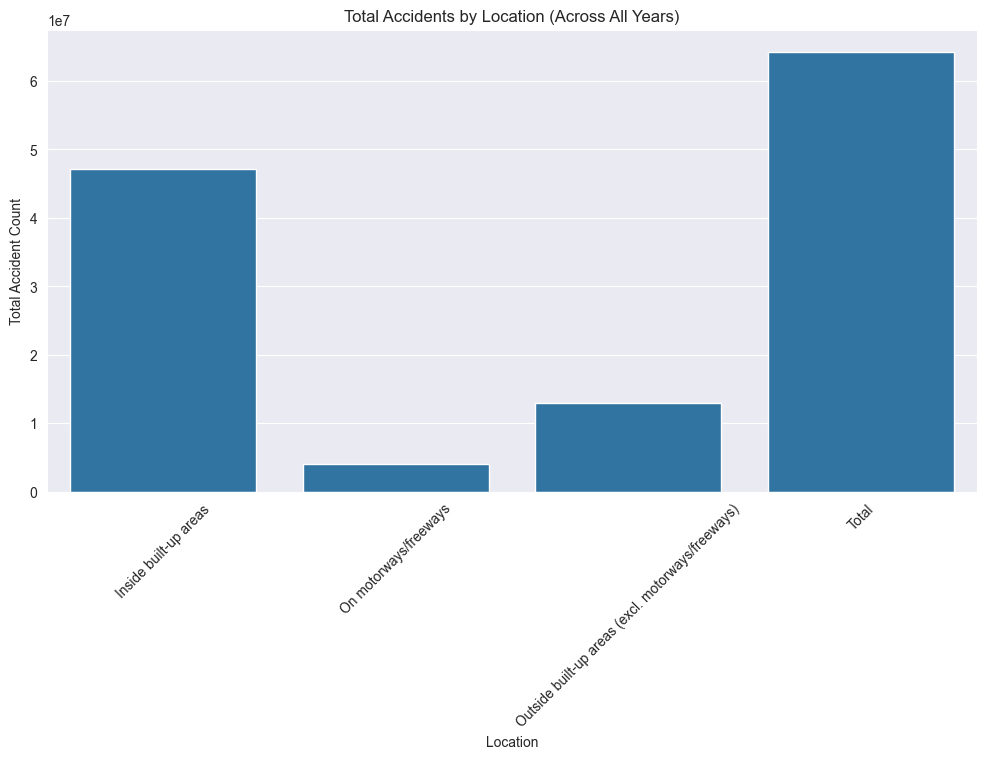

In [52]:
# Group by Location and sum the Accident_Count across all years
df_location_total = df_cleaned.groupby('Location')['Accident_Count'].sum().reset_index()

# Display the resulting data to check the totals
print(df_location_total)

# Plot the total accidents by location
plt.figure(figsize=(12, 6))
sns.barplot(data=df_location_total, x='Location', y='Accident_Count')
plt.title('Total Accidents by Location (Across All Years)')
plt.xlabel('Location')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.show()

   Month_Only  Accident_Count
4     January         9958260
3    February         9299612
7       March        10240556
0       April        10288204
8         May        11138588
6        June        11006664
5        July        10987804
1      August        10528216
11  September        11116688
10    October        11610496
9    November        11393552
2    December        10955072


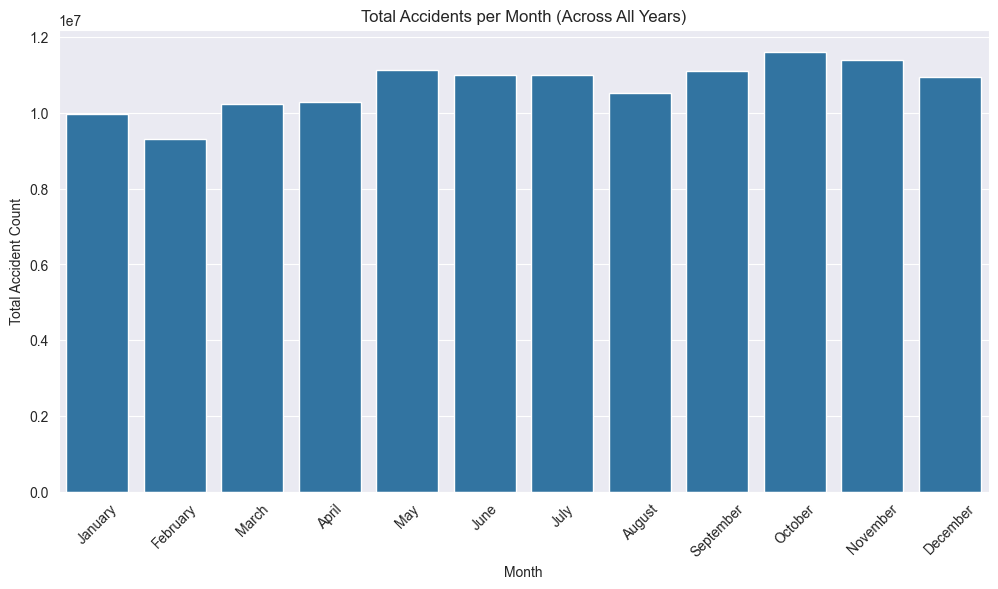

In [53]:
# Extract the month from the 'Date' column if it isn't already separated
df_cleaned['Month_Only'] = df_cleaned['Date'].dt.month_name()

# Group by the month and sum the Accident_Count across all years
df_month_total = df_cleaned.groupby('Month_Only')['Accident_Count'].sum().reset_index()

# Sort by month to keep the order of months (optional, if you want chronological order)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month_total['Month_Only'] = pd.Categorical(df_month_total['Month_Only'], categories=month_order, ordered=True)
df_month_total = df_month_total.sort_values('Month_Only')

# Display the resulting data to check the totals
print(df_month_total)

# Plot the total accidents per month
plt.figure(figsize=(12, 6))
sns.barplot(data=df_month_total, x='Month_Only', y='Accident_Count')
plt.title('Total Accidents per Month (Across All Years)')
plt.xlabel('Month')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.show()

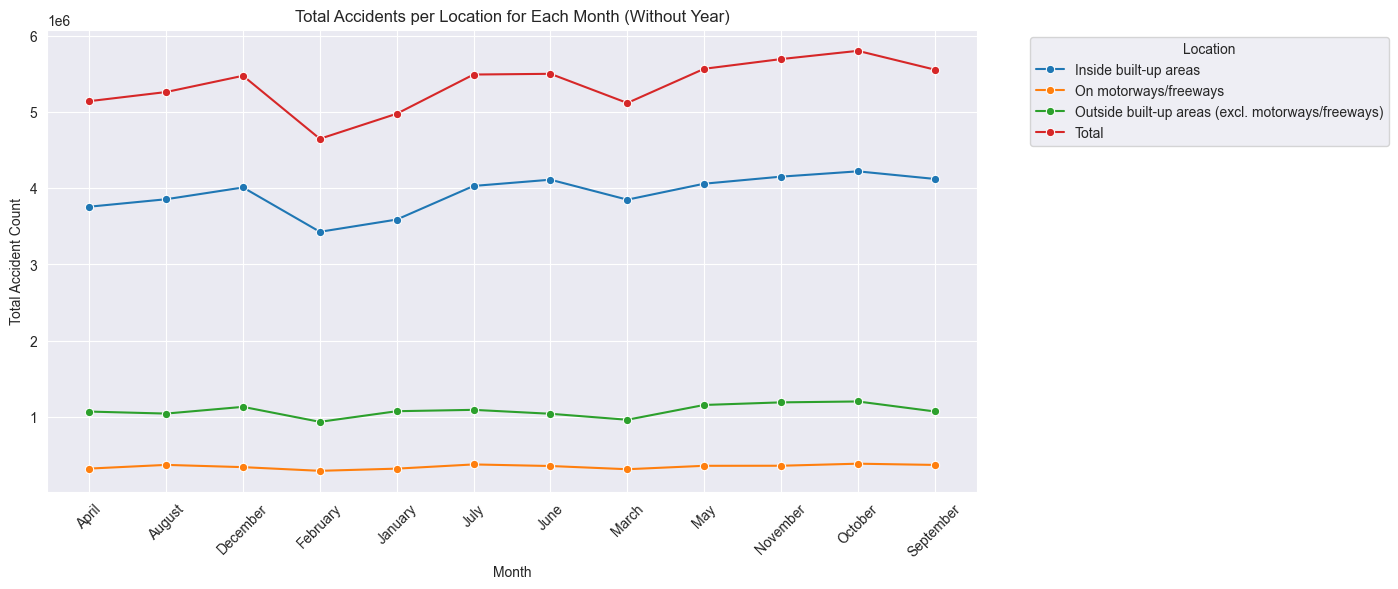

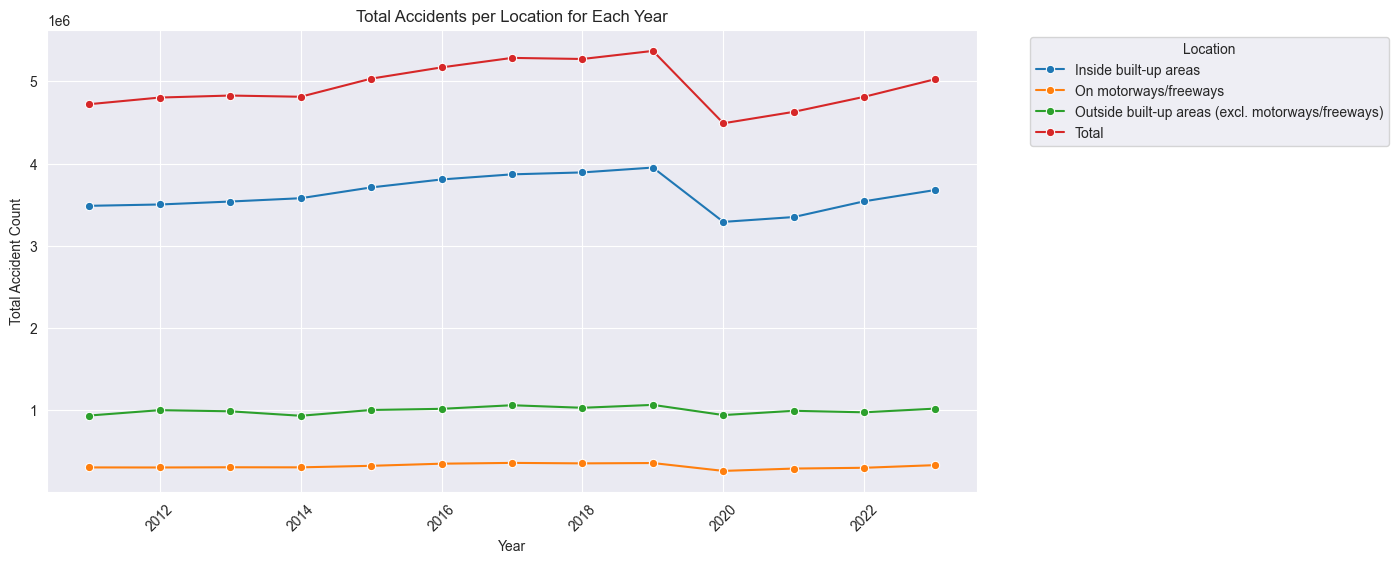

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Total Accidents by Location for Each Month (Without Years)
# Extract the month name (without the year)
df_cleaned['Month_Only'] = df_cleaned['Date'].dt.month_name()

# Group by Month_Only and Location, then sum the Accident_Count
df_location_monthly = df_cleaned.groupby(['Month_Only', 'Location'])['Accident_Count'].sum().reset_index()

# Plot the total accidents per location for each month (months without years)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_location_monthly, x='Month_Only', y='Accident_Count', hue='Location', marker='o')
plt.title('Total Accidents per Location for Each Month (Without Year)')
plt.xlabel('Month')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2️⃣ Total Accidents by Location for Each Year
# Extract the year from the Date column to group by year
df_cleaned['Year_Only'] = df_cleaned['Date'].dt.year

# Group by Year and Location, then sum the Accident_Count
df_location_yearly = df_cleaned.groupby(['Year_Only', 'Location'])['Accident_Count'].sum().reset_index()

# Plot the total accidents per location for each year
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_location_yearly, x='Year_Only', y='Accident_Count', hue='Location', marker='o')
plt.title('Total Accidents per Location for Each Year')
plt.xlabel('Year')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

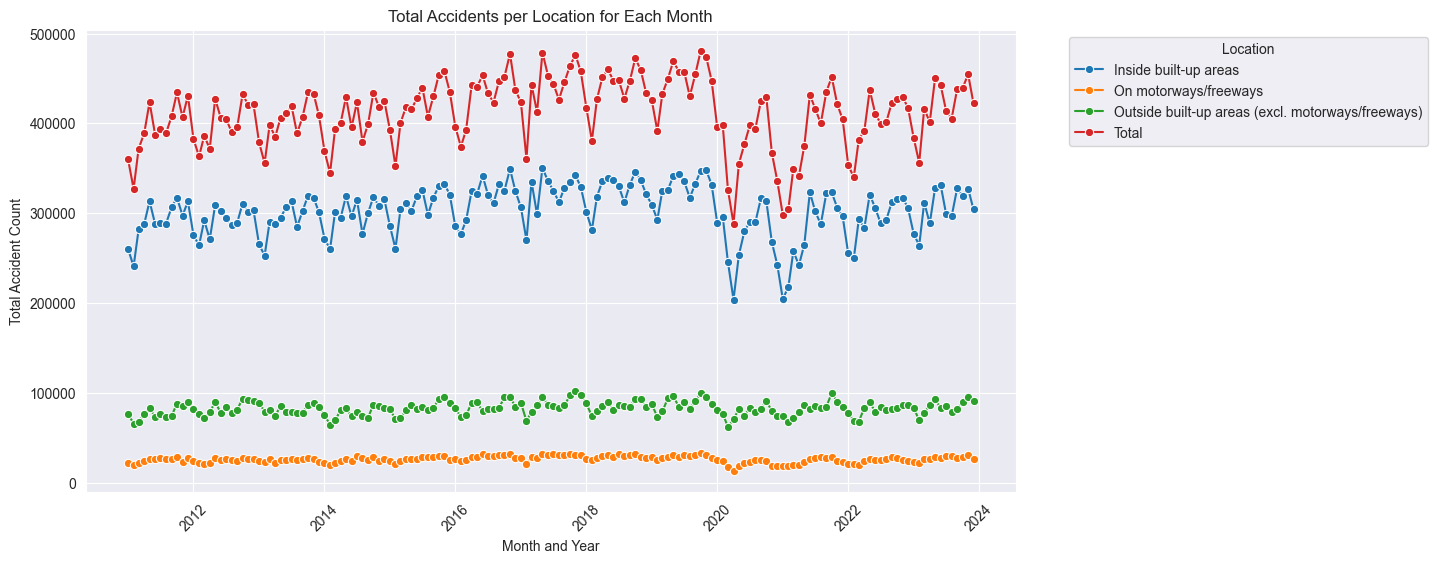

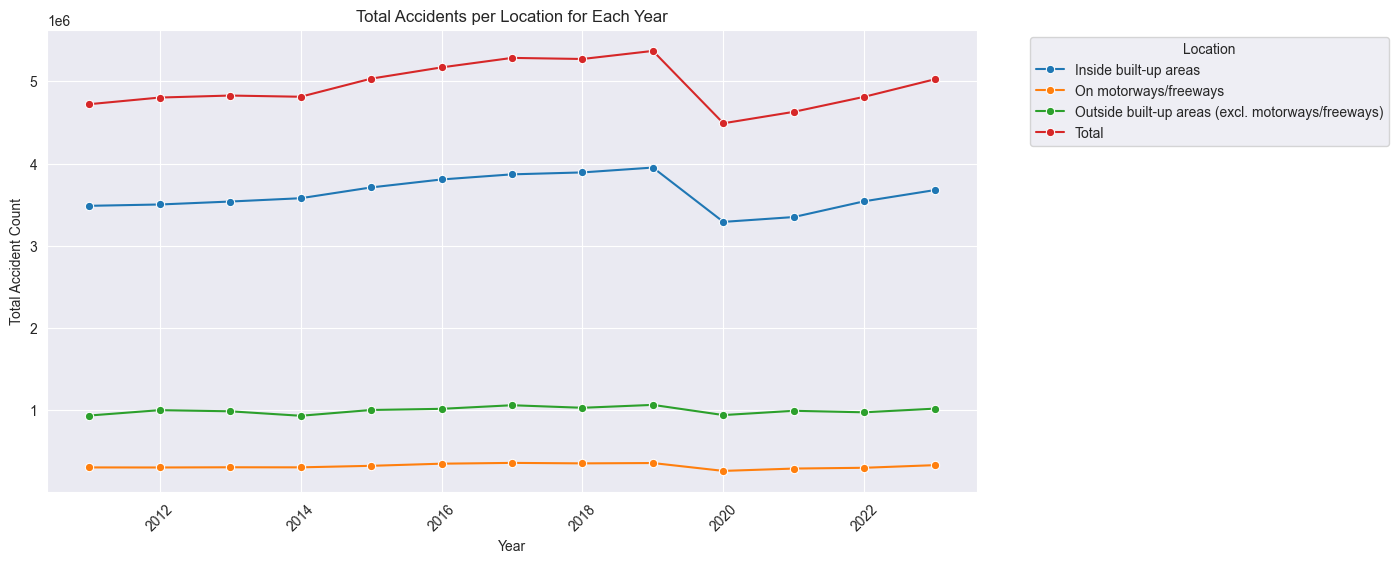

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Total Accidents by Location for Each Month
# Group by Date (Month) and Location, then sum the Accident_Count
df_location_monthly = df_cleaned.groupby(['Date', 'Location'])['Accident_Count'].sum().reset_index()

# Ensure 'Date' is in datetime format (if not already)
df_location_monthly['Date'] = pd.to_datetime(df_location_monthly['Date'])

# Plot the total accidents per location for each month
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_location_monthly, x='Date', y='Accident_Count', hue='Location', marker='o')
plt.title('Total Accidents per Location for Each Month')
plt.xlabel('Month and Year')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2️⃣ Total Accidents by Location for Each Year
# Extract the year from the Date column to group by year
df_cleaned['Year_Only'] = df_cleaned['Date'].dt.year

# Group by Year and Location, then sum the Accident_Count
df_location_yearly = df_cleaned.groupby(['Year_Only', 'Location'])['Accident_Count'].sum().reset_index()

# Plot the total accidents per location for each year
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_location_yearly, x='Year_Only', y='Accident_Count', hue='Location', marker='o')
plt.title('Total Accidents per Location for Each Year')
plt.xlabel('Year')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

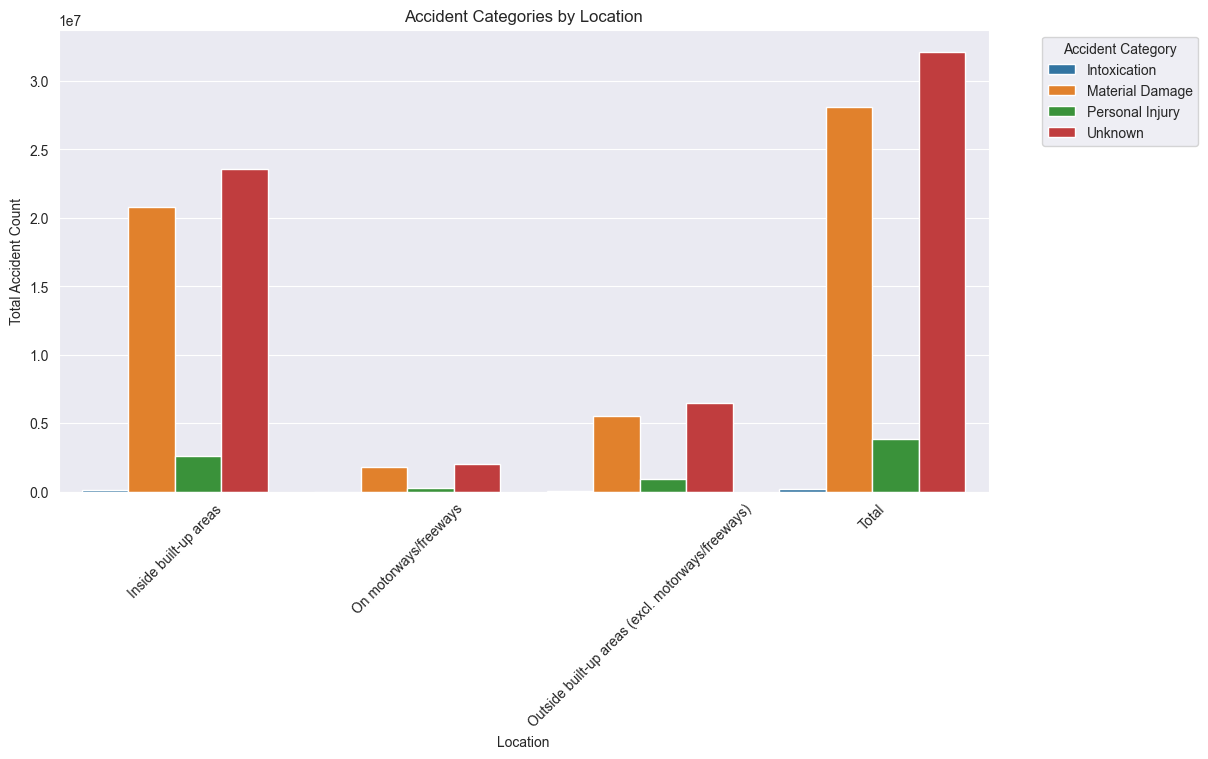

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Categorize Accident Type into Personal Injury, Material Damage, Intoxication, and Other Accidents
def categorize_accident_type(accident_type):
    if "personal injury" in accident_type.lower():
        return "Personal Injury"
    elif "mat.damage" in accident_type.lower() or "material damage" in accident_type.lower():
        return "Material Damage"
    elif "intoxication" in accident_type.lower():
        return "Intoxication"
    elif "other accidents involving material damage" in accident_type.lower():
        return "Other Material Damage"
    else:
        return "Unknown"

# Apply the categorization function to create a new column 'Accident_Category'
df_cleaned['Accident_Category'] = df_cleaned['Accident_Type'].apply(categorize_accident_type)

# 2️⃣ Group by Location and Accident Category, then sum the Accident_Count
df_category_location = df_cleaned.groupby(['Location', 'Accident_Category'])['Accident_Count'].sum().reset_index()

# 3️⃣ Plotting: Bar plot showing the number of accidents by category and location
plt.figure(figsize=(12, 6))
sns.barplot(data=df_category_location, x='Location', y='Accident_Count', hue='Accident_Category')
plt.title('Accident Categories by Location')
plt.xlabel('Location')
plt.ylabel('Total Accident Count')
plt.xticks(rotation=45)
plt.legend(title='Accident Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()